In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import aoflagger

plt.rcParams.update({'font.size': 18})

In [2]:
# h5_file = "../CAL_DATA/20250122-081736_pluto_3state.h5" #Original calibration experiment, had too many fluctuations
h5_file = "../CAL_DATA/20250122-084756_pluto_3state.h5" #Cold, ambient and hot run. This is the better one

Reading ../CAL_DATA/20250122-084756_pluto_3state.h5
1737506888.0535216


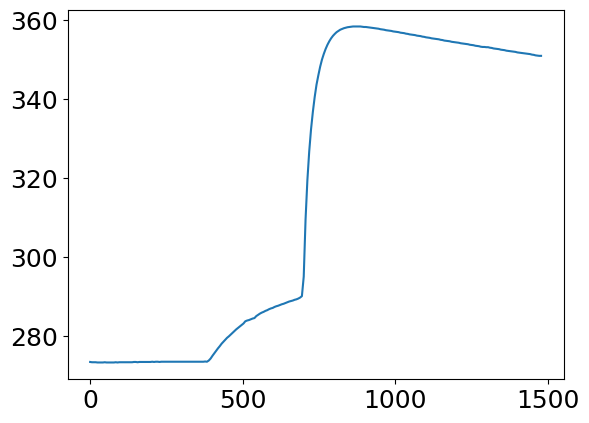

In [3]:
print ("Reading",h5_file)
hf = h5py.File(h5_file, 'r')

NFFT = hf["data"].attrs['NFFT']
fc   = hf["data"].attrs['fc']
fs   = hf["data"].attrs['fs']
gain = hf["data"].attrs['gain']
freq = np.linspace(fc-(fs/2), fc+(fs/2), NFFT)/1e6

len_data     = hf["data/timestamps"][()].shape[0]
len_cal_data = int(len_data/3)-1

ant_index  = np.where(hf["data/obssource"][()]==0)[0][0:len_cal_data]
cold_index = np.where(hf["data/obssource"][()]==1)[0][0:len_cal_data]
hot_index  = np.where(hf["data/obssource"][()]==2)[0][0:len_cal_data]

ant_data_raw  = hf["data/radio"][()][ant_index, :]
cold_data_raw = hf["data/radio"][()][cold_index, :]
hot_data_raw  = hf["data/radio"][()][hot_index, :]
temperature   = hf["data/temperature"][()][ant_index] + 273.15 #Convert to kelvins

ant_tstamps = hf["data/timestamps"][()][ant_index]
print (ant_tstamps[0])
ant_tstamps = ant_tstamps - ant_tstamps[0] #Absolute time irrelevant now

hf.close()

plt.figure()
plt.plot(ant_tstamps, temperature)

In [4]:
# #Flagging section

# ntimes     = ant_data_raw.shape[0]
# nch        = ant_data_raw.shape[1]
# flagger    = aoflagger.AOFlagger()
# path       = flagger.find_strategy_file(aoflagger.TelescopeId.Generic)
# strategy   = flagger.load_strategy_file(path)
# data       = flagger.make_image_set(nch, ntimes, 1)

# data.set_image_buffer(0, ant_data_raw) 
# flagvals_ant = strategy.run(data).get_buffer()

# data.set_image_buffer(0, cold_data_raw) 
# flagvalues_cold = strategy.run(data).get_buffer()

# data.set_image_buffer(0, hot_data_raw) 
# flagvalues_hot = strategy.run(data).get_buffer()

# flagvalues = np.logical_and(np.logical_and(flagvals_ant, flagvalues_cold), flagvalues_hot)
# flagvalues[:, 2045:2055] = True
# flagvalues[:, 2055:2070] = True
# flagvalues[115:140, :]   = True #Non equilibrium conditions, differential heating between the load and temperature sensor very likely !

# plt.figure()
# plt.imshow(flagvalues, aspect='auto')

# ant_data  = np.ma.array(ant_data_raw, mask=(np.array(flagvalues, dtype=bool)))
# cold_data = np.ma.array(cold_data_raw, mask=(np.array(flagvalues, dtype=bool)))
# hot_data  = np.ma.array(hot_data_raw, mask=(np.array(flagvalues, dtype=bool)))

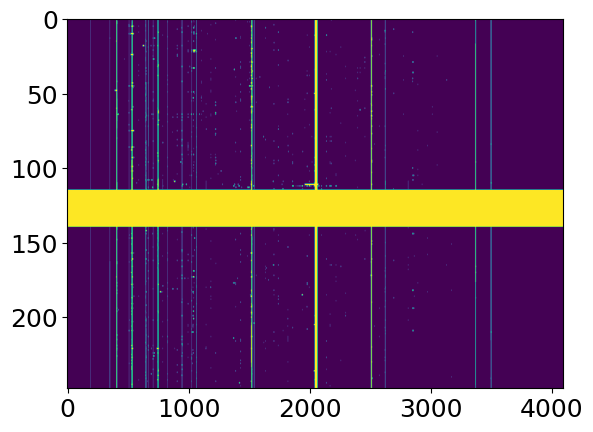

In [5]:
# Flagging section, this ought to be right way (ntimes, nch ordering) to do it

ntimes     = ant_data_raw.shape[0]
nch        = ant_data_raw.shape[1]
flagger    = aoflagger.AOFlagger()
path       = flagger.find_strategy_file(aoflagger.TelescopeId.Generic)
strategy   = flagger.load_strategy_file(path)
data       = flagger.make_image_set(ntimes, nch, 1)

data.set_image_buffer(0, ant_data_raw.T) 
flagvals_ant = strategy.run(data).get_buffer().T

data.set_image_buffer(0, cold_data_raw.T) 
flagvalues_cold = strategy.run(data).get_buffer().T

data.set_image_buffer(0, hot_data_raw.T) 
flagvalues_hot = strategy.run(data).get_buffer().T

flagvalues = np.logical_and(np.logical_and(flagvals_ant, flagvalues_cold), flagvalues_hot)
flagvalues[:, 2045:2055] = True
flagvalues[:, 2055:2070] = True
flagvalues[115:140, :]   = True #Non equilibrium conditions, differential heating between the load and temperature sensor very likely !

plt.figure()
plt.imshow(flagvalues, aspect='auto')

ant_data  = np.ma.array(ant_data_raw, mask=(np.array(flagvalues, dtype=bool)))
cold_data = np.ma.array(cold_data_raw, mask=(np.array(flagvalues, dtype=bool)))
hot_data  = np.ma.array(hot_data_raw, mask=(np.array(flagvalues, dtype=bool)))

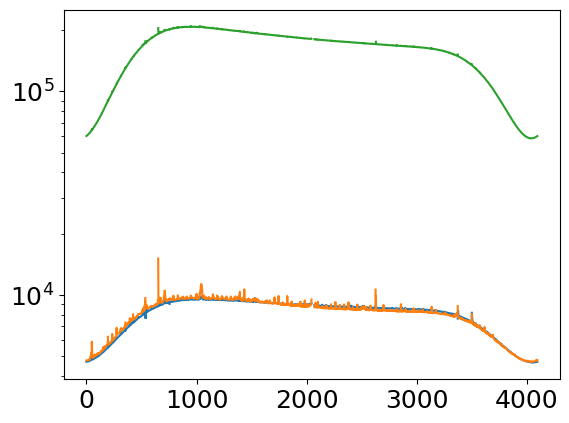

In [6]:
plt.figure()
plt.semilogy(np.ma.mean(ant_data, axis=0))
plt.semilogy(np.ma.mean(cold_data, axis=0))
plt.semilogy(np.ma.mean(hot_data, axis=0))



In [7]:
ant_calibrated = ant_data/(hot_data - cold_data)
cold_calibrated = cold_data/(hot_data - cold_data)
hot_calibrated = hot_data/(hot_data - cold_data)

mean_ant_power = np.ma.mean(ant_calibrated, axis=1)
mean_cold_power = np.ma.mean(cold_calibrated, axis=1)
mean_hot_power = np.ma.mean(hot_calibrated, axis=1)

mean_ant_spectrum = np.ma.mean(ant_calibrated, axis=0)
mean_cold_spectrum = np.ma.mean(cold_calibrated, axis=0)
mean_hot_spectrum = np.ma.mean(hot_calibrated, axis=0)

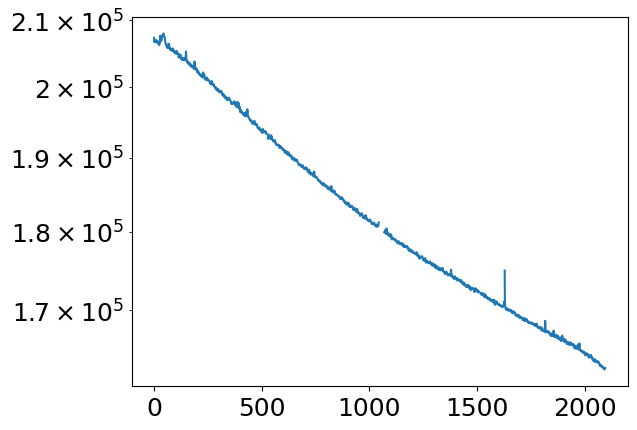

In [8]:
edge_chans = int(1000)

plt.figure()
plt.semilogy(np.ma.mean(hot_data, axis=0)[edge_chans:-edge_chans])
# plt.xlim(0, 2000)

Estimated T_RX = 368.8987704440179 K
Estimated ENR (lin) = 13542.991765193317 K
Estimated ENR (dB)  = 16.641087058274152 dB


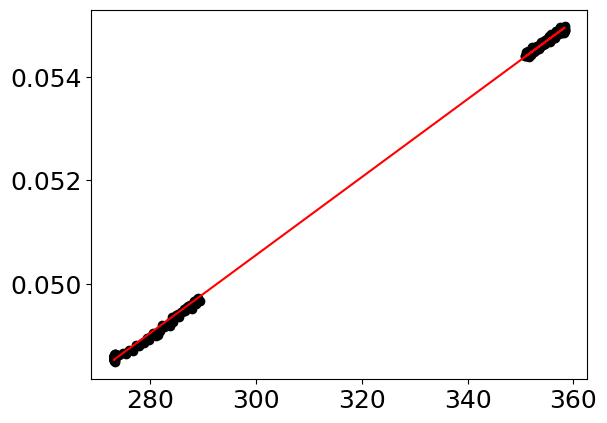

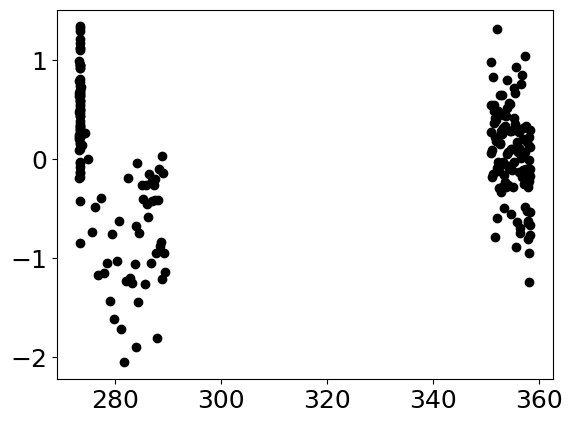

In [15]:
mean_ant_cal_power_4fit = np.ma.mean(ant_calibrated[:, edge_chans:-edge_chans], axis=1)

pfit_c = np.ma.polyfit(temperature, mean_ant_cal_power_4fit, 1)
s_line = temperature*pfit_c[0] + pfit_c[1]

plt.figure()
plt.scatter(temperature, mean_ant_cal_power_4fit, color='black')
plt.plot(temperature, s_line, color='red')

gain = pfit_c[0]
T_RX = pfit_c[1]/pfit_c[0]

plt.figure()
plt.scatter(temperature, (mean_ant_cal_power_4fit)/gain-T_RX-temperature, color='black')

mean_ant_spectrum_tcal   = (mean_ant_spectrum/gain) - T_RX
mean_cold_spectrum_tcal  = (mean_cold_spectrum/gain) - T_RX
mean_hot_spectrum_tcal   = (mean_hot_spectrum/gain) - T_RX

ENR = np.ma.mean(mean_hot_spectrum_tcal[edge_chans:-edge_chans])

ENR_dB = 10*np.log10((ENR/300)+1)

print ("Estimated T_RX =", T_RX, "K")
print ("Estimated ENR (lin) =", ENR, "K")
print ("Estimated ENR (dB)  =", ENR_dB, "dB")

# plt.figure()
# plt.plot(freq[edge_chans:-edge_chans], t_step_cal_spectrum[edge_chans:-edge_chans])
# plt.ylim(1e4, 2e4)

In [18]:
chunk_size = 20
T_RX_spectrum = np.zeros(4096)
for chan_index in range(4096-20):
    # mean_ant_cal_power_4fit = np.ma.mean(ant_calibrated[:, chan_index:chan_index+chunk_size], axis=1)
    # pfit_c = np.ma.polyfit(temperature, mean_ant_cal_power_4fit, 1)

    mean_ant_cal_power_4fit = np.mean(ant_calibrated[:, chan_index:chan_index+chunk_size], axis=1)
    pfit_c = np.polyfit(temperature, mean_ant_cal_power_4fit, 1)
    T_RX_spectrum[chan_index] = pfit_c[1]/pfit_c[0]

/tmp/ipykernel_50117/2939227493.py:9: RuntimeWarning: invalid value encountered in scalar divide
  T_RX_spectrum[chan_index] = pfit_c[1]/pfit_c[0]


(-10000.0, 0.0)

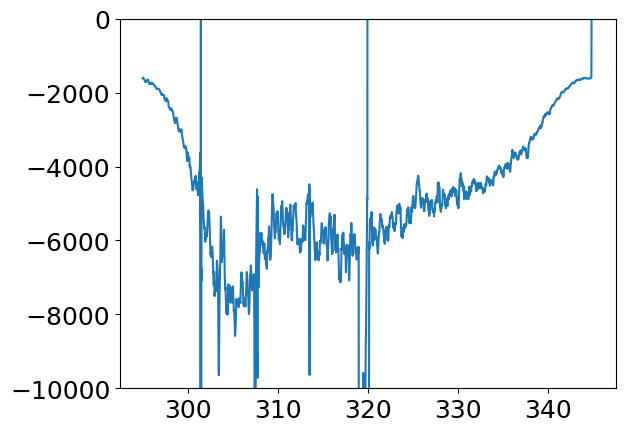

In [20]:
plt.figure()
plt.plot(freq, T_RX_spectrum)
plt.ylim(-10000, 0)

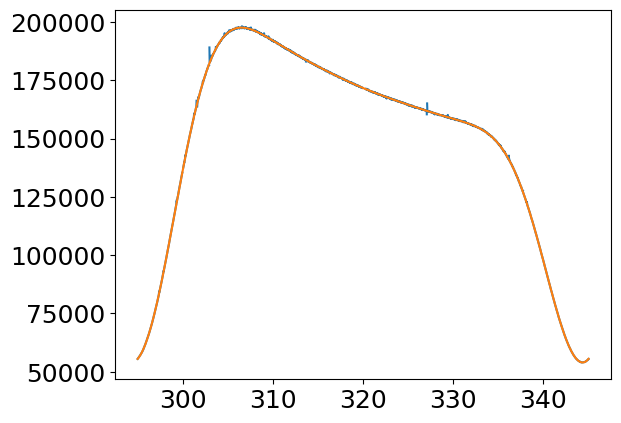

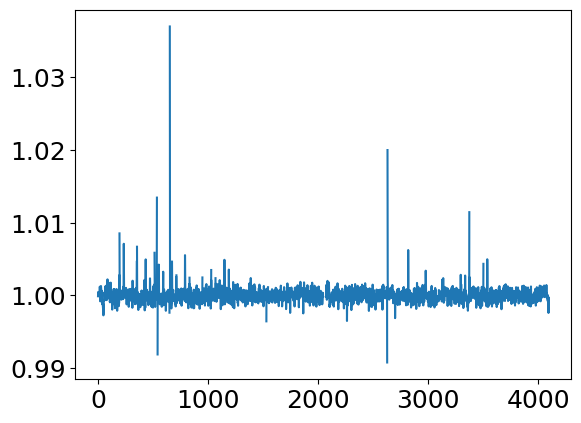

In [10]:
mean_bp = np.ma.mean(hot_data - cold_data, axis=0)

# pfit_c2 = np.ma.polyfit(np.linspace(-1,1,4096)[edge_chans:-edge_chans], mean_bp[edge_chans:-edge_chans], 6)
# bp_poly = np.polyval(pfit_c2, np.linspace(-1,1,4096)[edge_chans:-edge_chans])

# plt.figure()
# plt.plot(freq[edge_chans:-edge_chans], mean_bp[edge_chans:-edge_chans])
# plt.plot(freq[edge_chans:-edge_chans], bp_poly)

pfit_c2 = np.ma.polyfit(np.linspace(-1,1,4096), mean_bp, 16)
bp_poly = np.polyval(pfit_c2, np.linspace(-1,1,4096))

plt.figure()
plt.plot(freq, mean_bp)
plt.plot(freq, bp_poly)

plt.figure()
# plt.plot(freq, mean_bp-bp_poly)

plt.plot(np.ma.mean(hot_data - cold_data, axis=0)/bp_poly)
